**Note**: the code in this notebook is not mine. It's here for learning purpose only.
[Original Code](https://www.kaggle.com/code/alkidiarete/apple-quality-roc-0-97)

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
from scipy import stats
from colorama import Fore, init
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(style="whitegrid")

# 2. Import Data


In [2]:
df = pd.read_csv("./apple_quality.csv")
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


<Axes: >

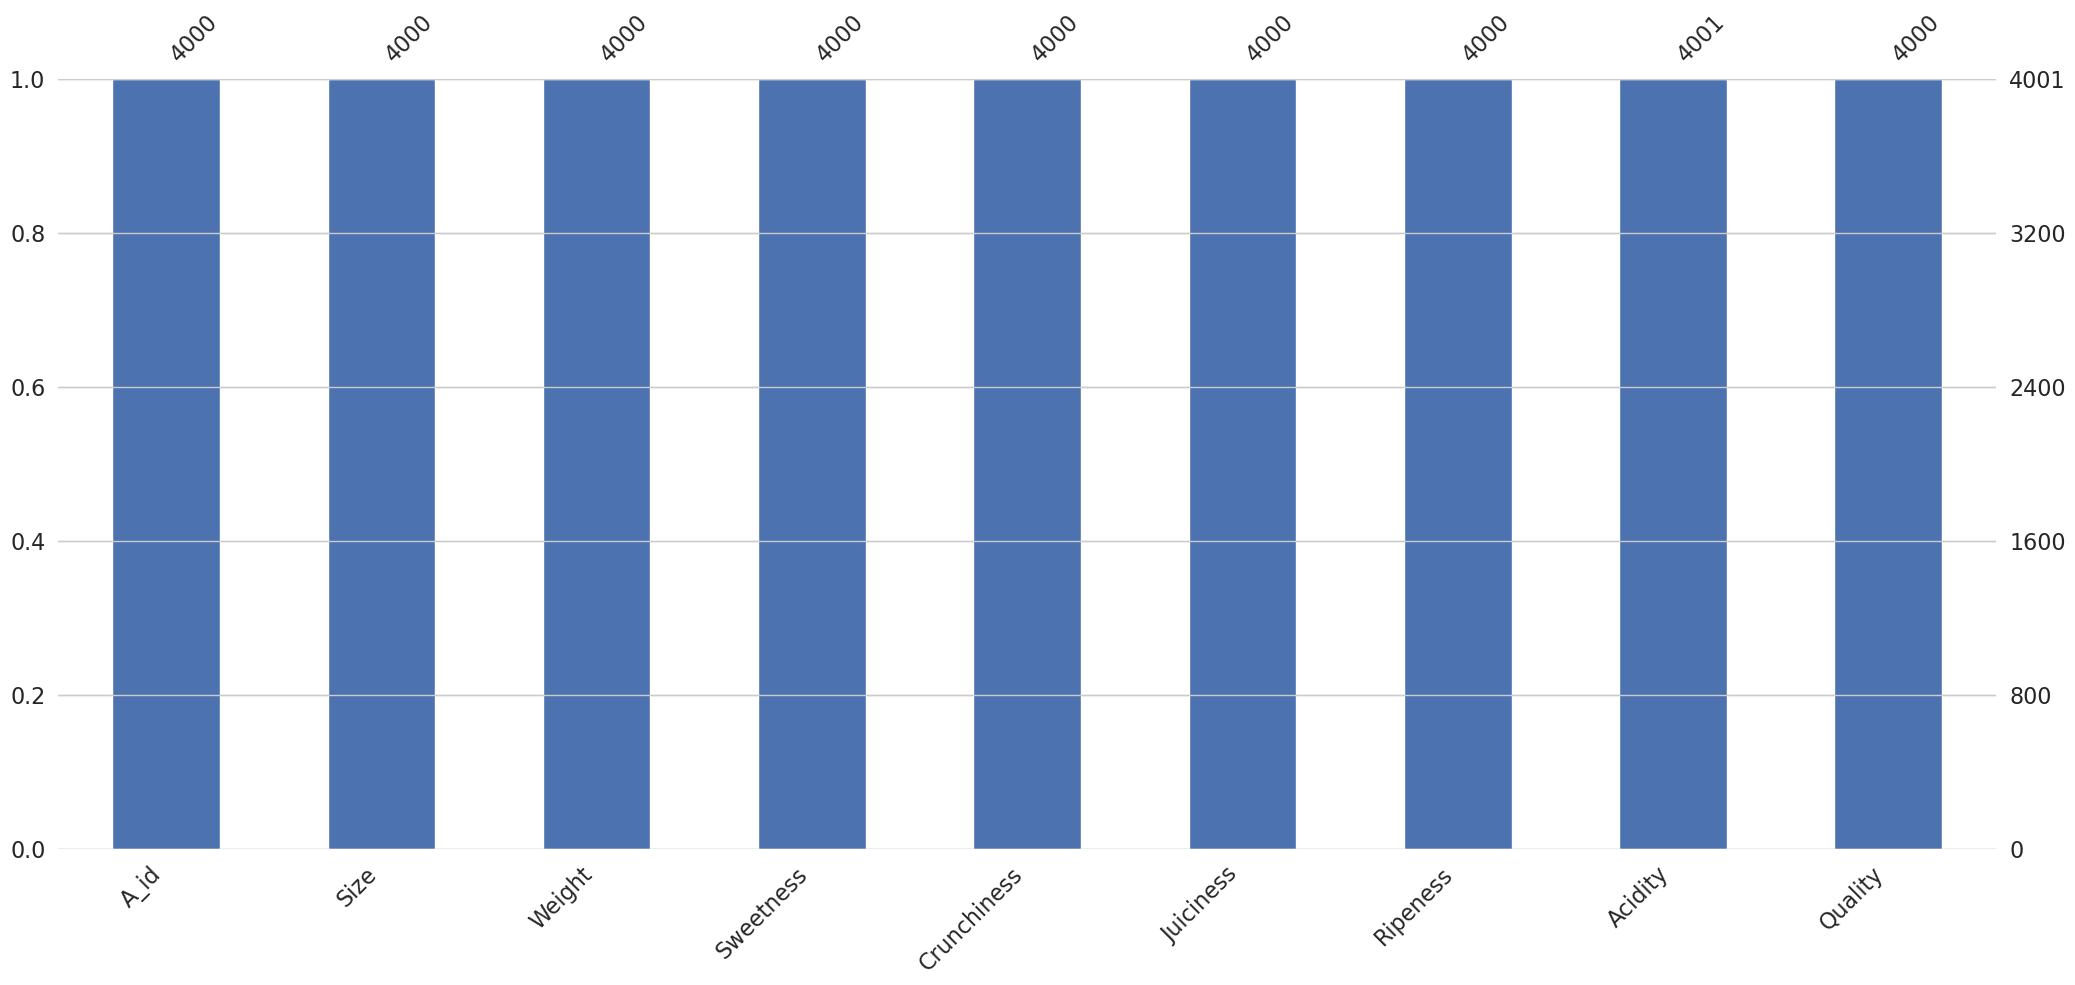

In [4]:
msno.bar(df, color='b')

In [5]:
df.describe().T.style.background_gradient(axis=0, cmap="cubehelix")

,count,mean,std,min,25%,50%,75%,max
A_id,4000.000000,1999.500000,1154.844867,0.000000,999.750000,1999.500000,2999.250000,3999.000000
Size,4000.000000,-0.503015,1.928059,-7.151703,-1.816765,-0.513703,0.805526,6.406367
Weight,4000.000000,-0.989547,1.602507,-7.149848,-2.011770,-0.984736,0.030976,5.790714
Sweetness,4000.000000,-0.470479,1.943441,-6.894485,-1.738425,-0.504758,0.801922,6.374916
Crunchiness,4000.000000,0.985478,1.402757,-6.055058,0.062764,0.998249,1.894234,7.619852
Juiciness,4000.000000,0.512118,1.930286,-5.961897,-0.801286,0.534219,1.835976,7.364403
Ripeness,4000.000000,0.498277,1.874427,-5.864599,-0.771677,0.503445,1.766212,7.237837


In [6]:
df.duplicated().sum()

0

In [7]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

A_id: 4001 distinct values
Size: 4001 distinct values
Weight: 4001 distinct values
Sweetness: 4001 distinct values
Crunchiness: 4001 distinct values
Juiciness: 4001 distinct values
Ripeness: 4001 distinct values
Acidity: 4001 distinct values
Quality: 3 distinct values


In [8]:
df[df.isnull().any(axis=1)]

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Created_by_Nidula_Elgiriyewithana,NaN


# 3. Data Exploration

## 3.1 Data Cleaning

In [9]:
def clean_data(df):
    df = df.dropna()
    # IMPORTANT: "'good'  => 0 'bad'   => 1"
    df["Label"] = df["Quality"].replace(["good", "bad"], [0, 1])
    df = df.drop(columns=["A_id", "Quality"])
    df = df.astype({"Acidity": "float64", "Label": "int64"})
    return df

df_clean = clean_data(df.copy())
df_clean.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Label
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,0
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,0
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,1
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,0
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,0


In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4000 non-null   float64
 7   Label        4000 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 281.2 KB


## 3.2 Visualization

### 3.2.1 Univariate


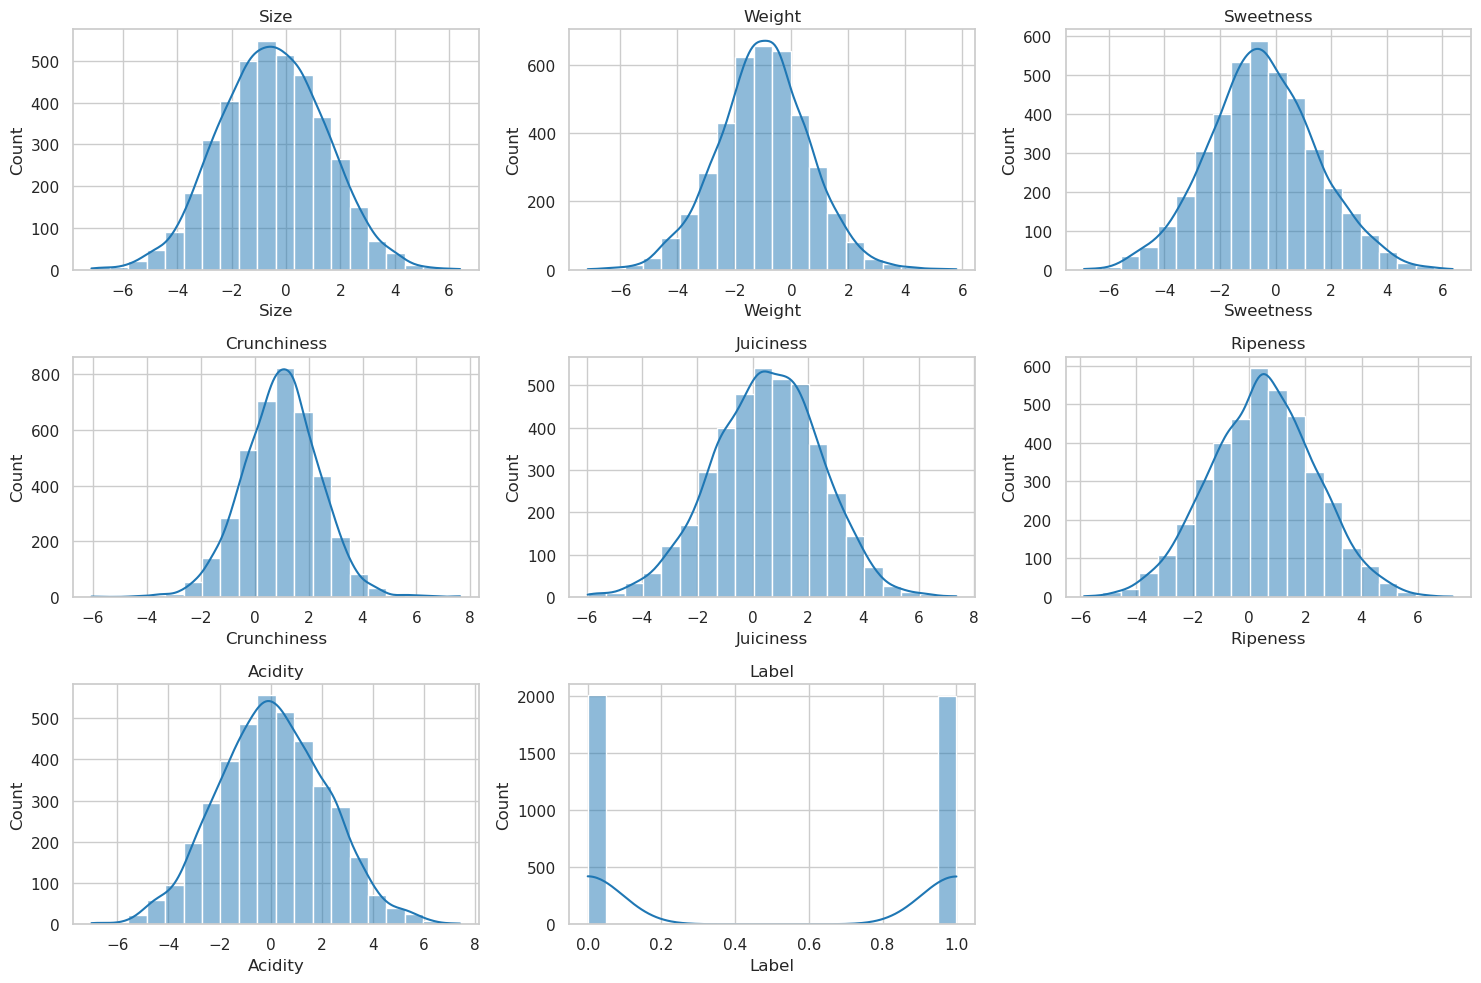

In [14]:
numerical_cols = ["Size", "Weight", "Sweetness", "Crunchiness", "Juiciness", "Ripeness", "Acidity", "Label"]

plt.figure(figsize=(15, 10))
sns.set_palette("tab10")

for i, column in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df_clean, x=column, kde=True, bins=20)  # Use sns.histplot for newer versions
    plt.title(column)

plt.tight_layout()
plt.show()

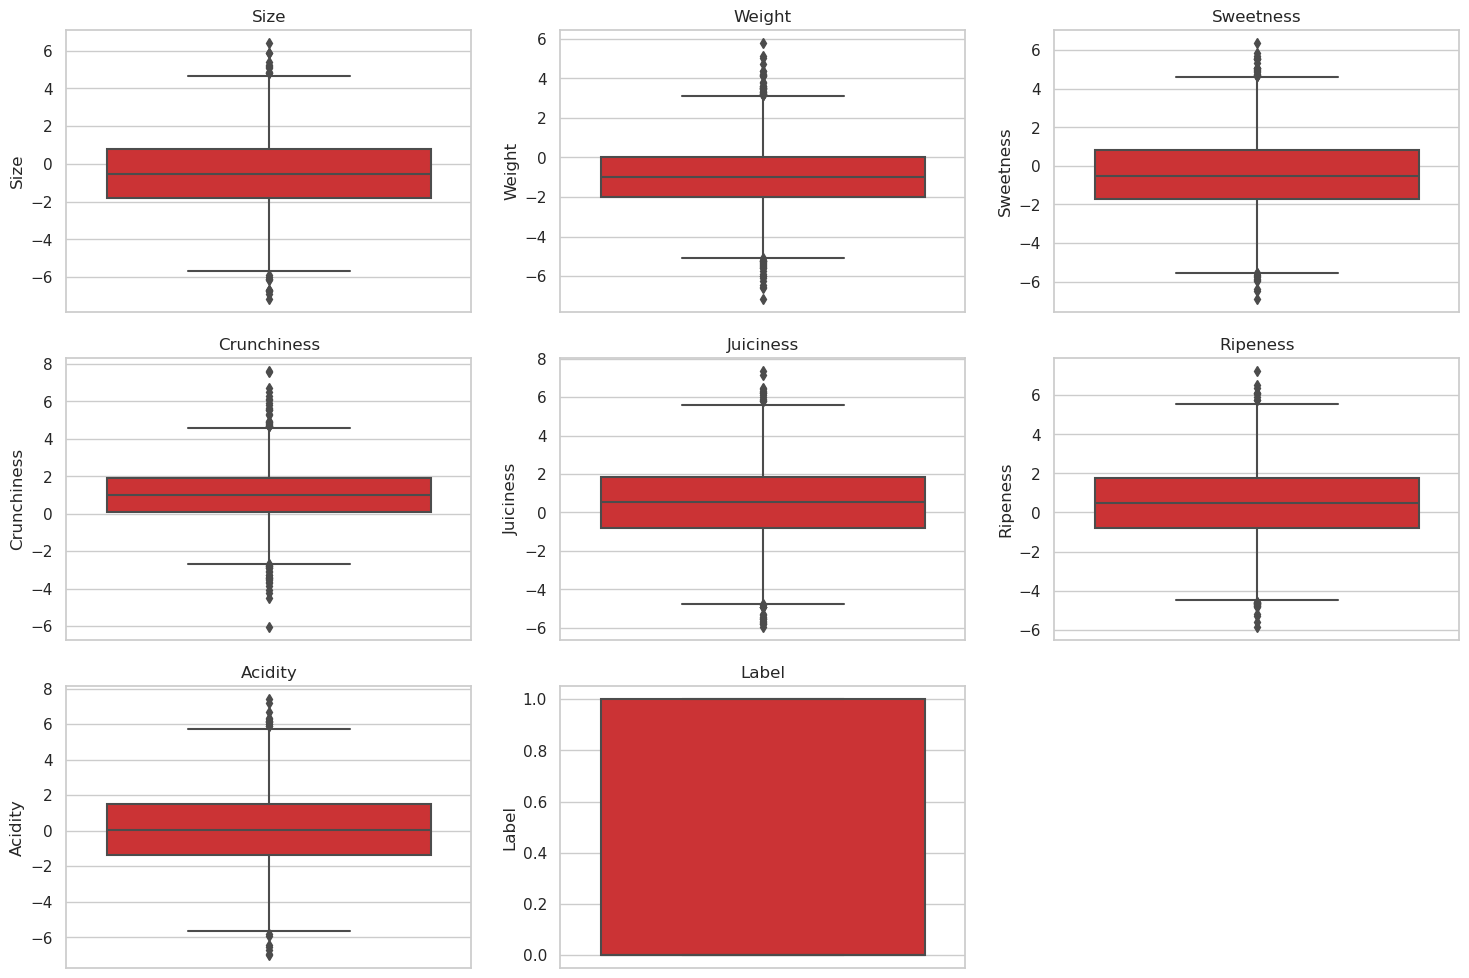

In [18]:
plt.figure(figsize=(15, 10))
sns.set_palette("Set1")
for i, column in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df_clean[column])
    plt.title(column)

plt.tight_layout()
plt.show()

### 3.2.2 Bivariate

In [19]:
df_clean.columns[:-1]

Index(['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness',
       'Acidity'],
      dtype='object')

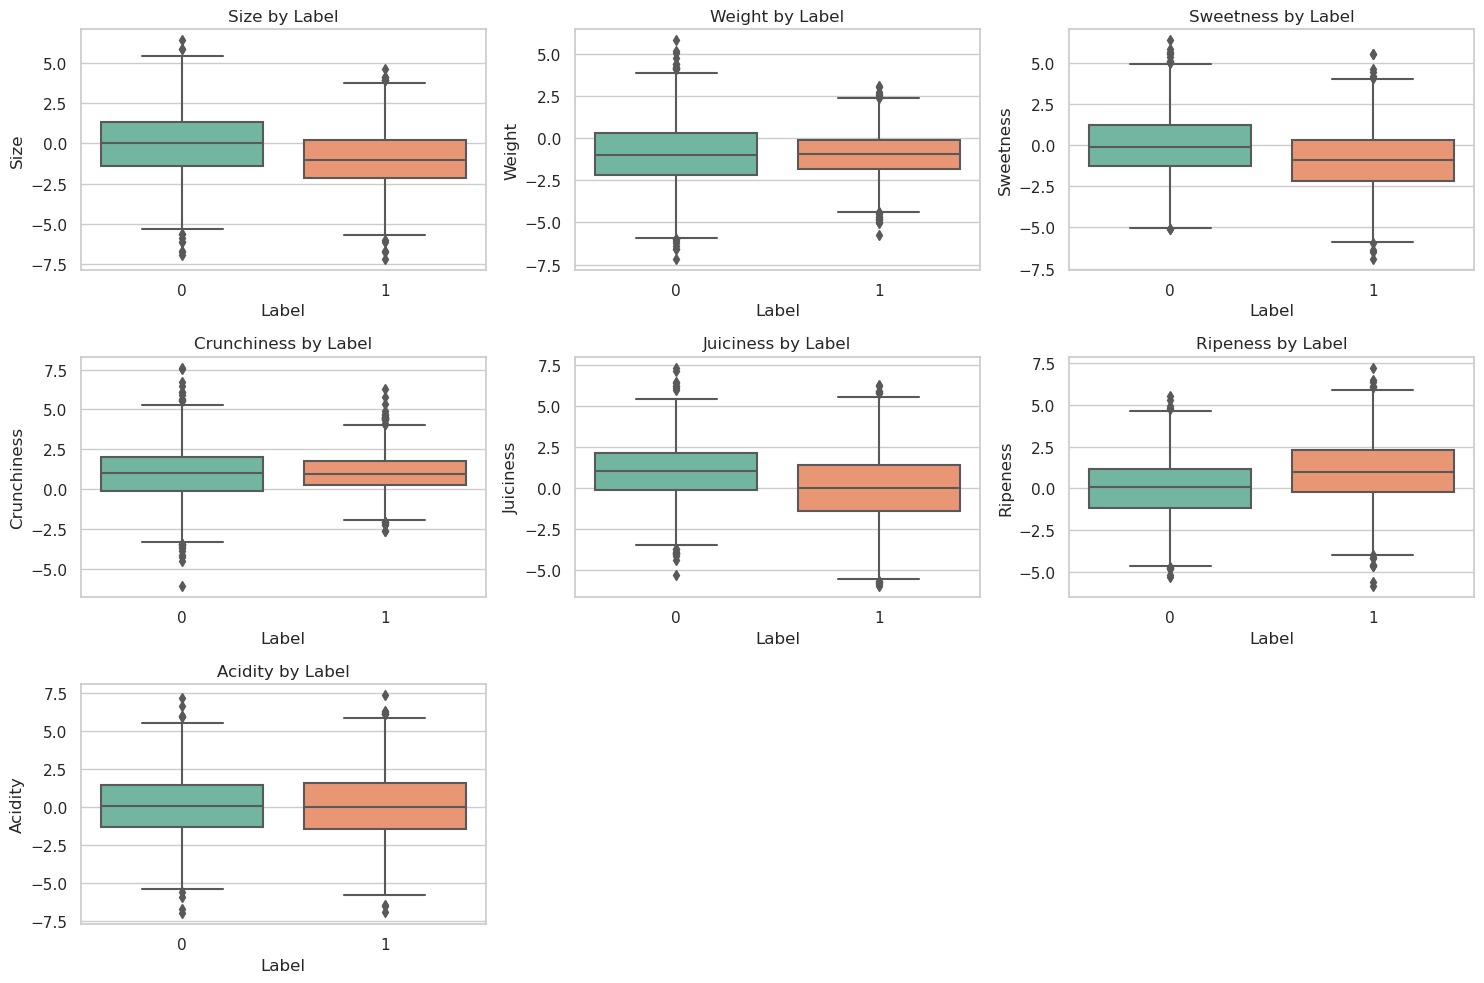

In [20]:
plt.figure(figsize=(15, 10))
sns.set_palette("Set2")

for i, column in enumerate(df_clean.columns[:-1]):  
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='Label', y=column, data=df_clean)
    plt.title(f'{column} by Label')

plt.tight_layout()
plt.show()

### 3.2.3 Multivariate

<Figure size 800x800 with 0 Axes>

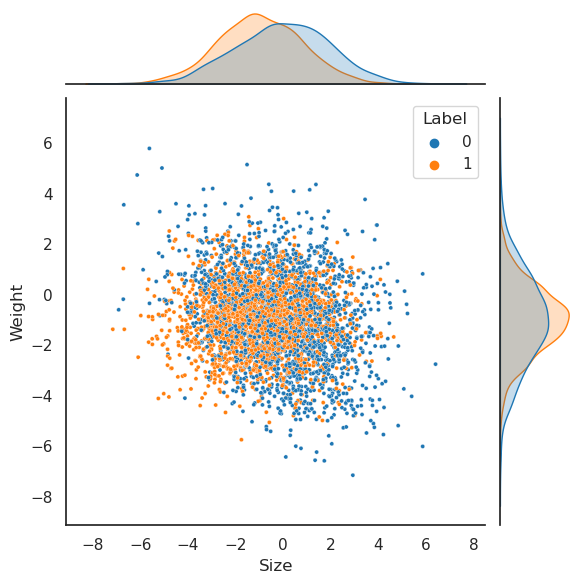

In [21]:
plt.figure(figsize=(8,8))
sns.set_style("white")

sns.jointplot(x="Size", y="Weight", hue="Label", data=df_clean, palette='tab10', s=9)

<Figure size 800x800 with 0 Axes>

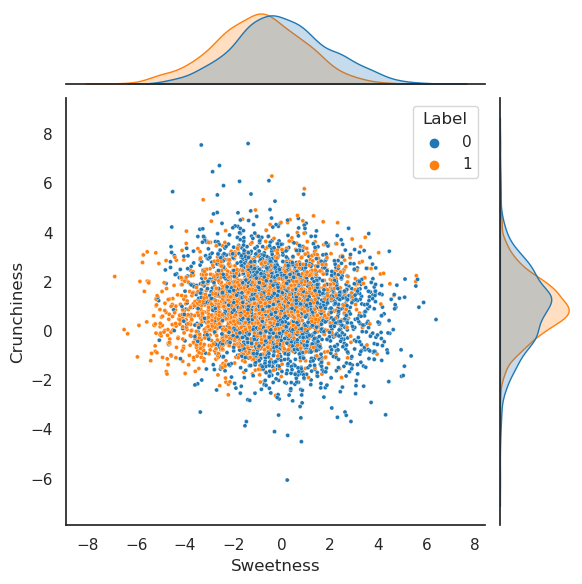

In [22]:
plt.figure(figsize=(8, 8))
sns.set_style("white")

sns.jointplot(x="Sweetness", y="Crunchiness", data=df_clean, hue='Label', palette='tab10', s=9)

<Figure size 800x800 with 0 Axes>

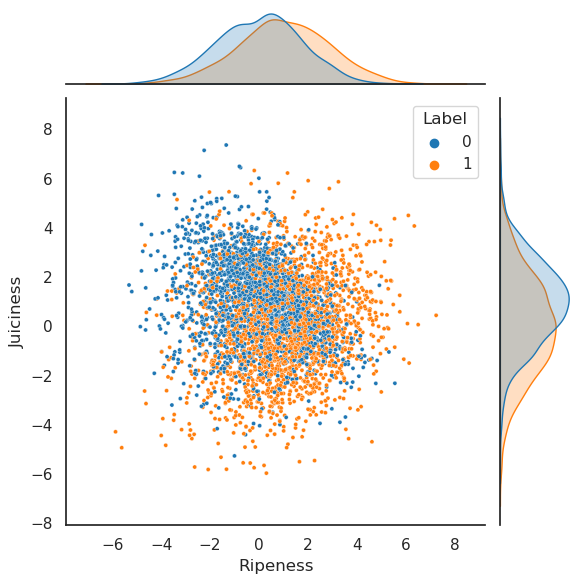

In [23]:
plt.figure(figsize=(8, 8))
sns.set_style("white")

sns.jointplot(x="Ripeness", y="Juiciness", data=df_clean, hue='Label', palette='tab10', s=9)

### 3.3 Correlation Heatmap

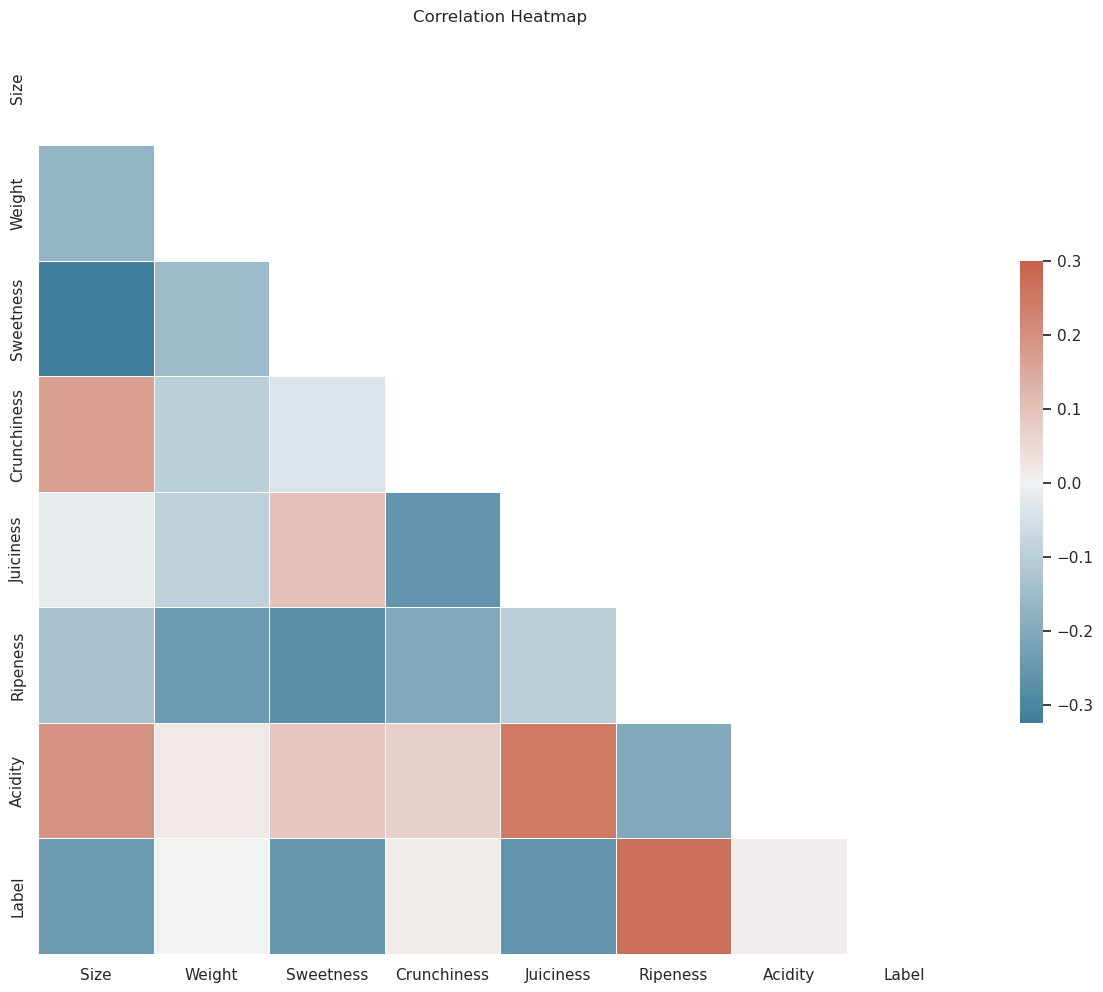

In [24]:
corr = df_clean.corr()

mask = np.triu(np.ones_like(corr, dtype=bool)) # upper triangular

plt.figure(figsize=(15, 12))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title("Correlation Heatmap")
plt.show()

# 4. Preprocesing


## 4.1 Outliers

In [25]:
numerical_features = ["Size", "Weight", "Sweetness", "Crunchiness", "Juiciness", "Ripeness", "Acidity"]

robust_scaler = RobustScaler() # Scale features using statistics that are robust to outliers.
df_clean[numerical_features] = robust_scaler.fit_transform(df_clean[numerical_features])

def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3-Q1 # IQR: Interquartile Range from .25 to .75
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series<lower_bound) | (series>upper_bound)).sum()

for feature in numerical_features:
    num_outliers = count_outliers(df_clean[feature])
    print(f"Number of outliers in {feature}: {num_outliers}")

Number of outliers in Size: 22
Number of outliers in Weight: 54
Number of outliers in Sweetness: 32
Number of outliers in Crunchiness: 47
Number of outliers in Juiciness: 32
Number of outliers in Ripeness: 24
Number of outliers in Acidity: 20


In [26]:
scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
df_clean[numerical_features] = scaler.fit_transform(df_clean[numerical_features])

## 4.2 Hypothesis Testing

Hypothesis testing is a statistical method used to make decisions based on sample data regarding a proposed claim or hypothesis about a population. In this process, we examine whether the evidence found from the sample is sufficiently strong to support or contradict a statement about a population parameter.

T-Statistics 6.950226687826504e-16
P-Value 0.9999999999999994


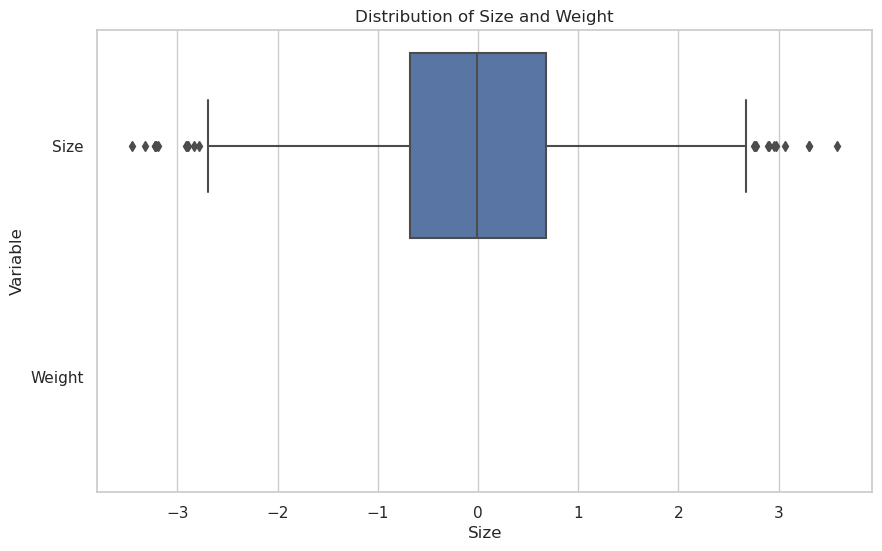

T-Statistics -3.971558107329431e-16
P-Value 0.9999999999999997


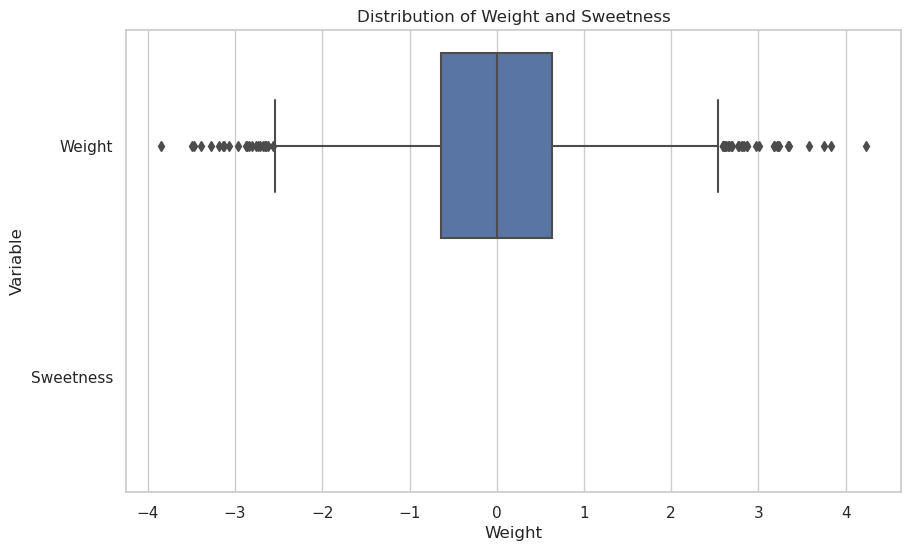

T-Statistics 9.730317362957104e-16
P-Value 0.9999999999999992


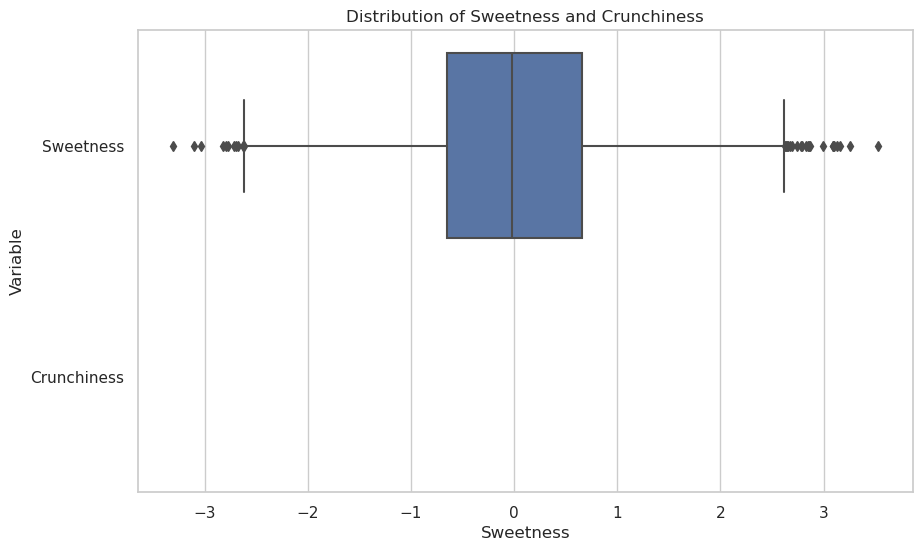

T-Statistics -1.707769986151655e-15
P-Value 0.9999999999999987


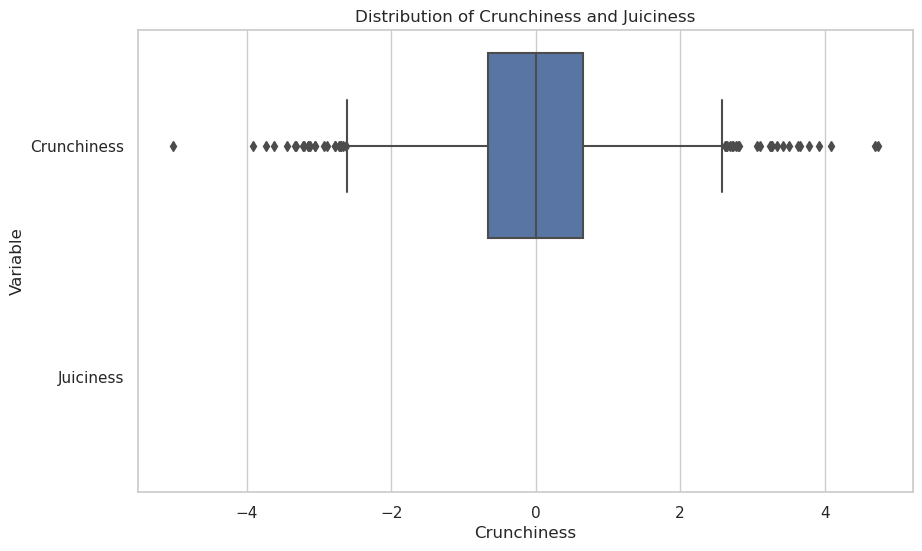

T-Statistics 1.707769986151655e-15
P-Value 0.9999999999999987


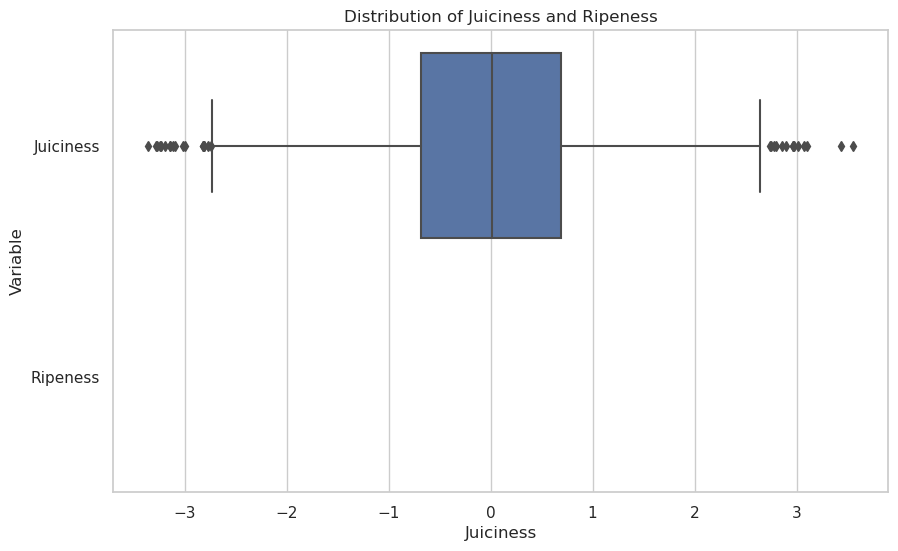

T-Statistics -1.5886232429317723e-16
P-Value 0.9999999999999999


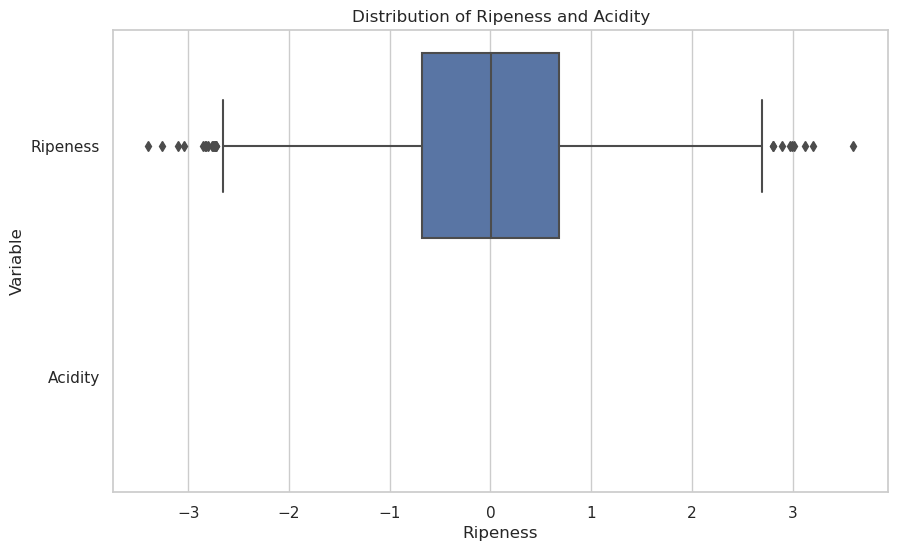

In [27]:
sns.set(style="whitegrid")

def hypothesis_testing(df, column1, column2):
    t_stat, p_val = stats.ttest_ind(df[column1], df[column2])

    print(f"T-Statistics {t_stat}")
    print(f"P-Value {p_val}")

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column1], y="Variable", data=pd.melt(df[[column1, column2]], var_name="Variable"))
    
    plt.title(f"Distribution of {column1} and {column2}")
    plt.show()

columns_for_testing = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']
for i in range(len(columns_for_testing)-1):
    hypothesis_testing(df_clean, columns_for_testing[i], columns_for_testing[i+1])

## 4.3 Imbalance Data

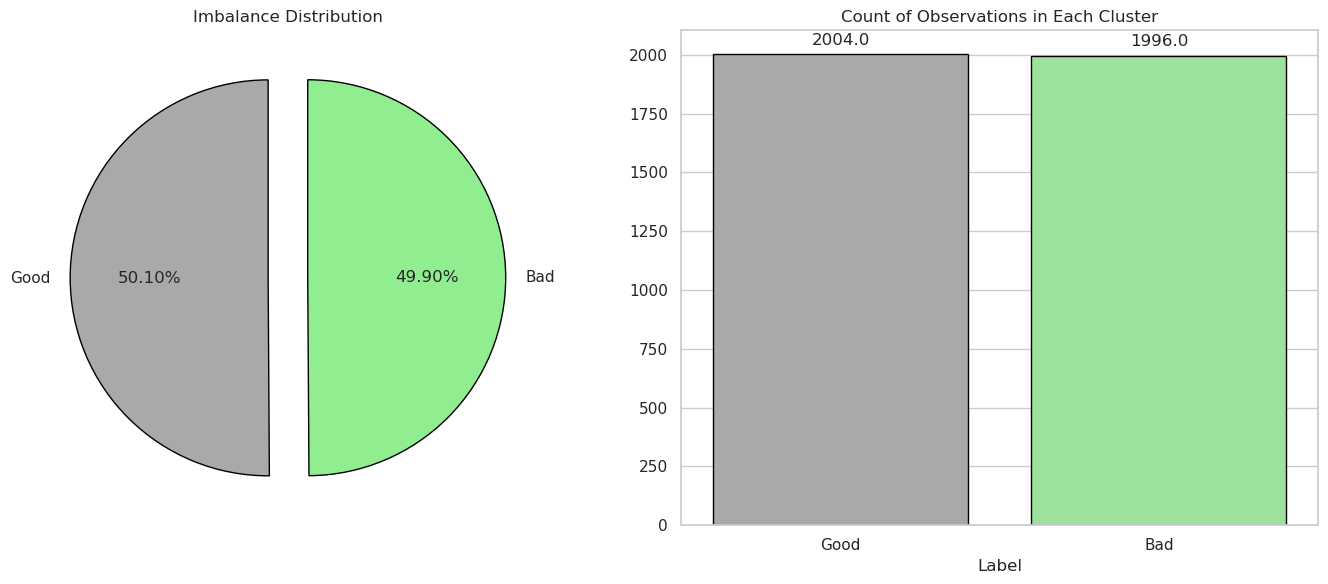

In [31]:
good_count = df_clean["Label"].eq(0).sum()
bad_count = df_clean["Label"].eq(1).sum()
total_count = len(df_clean)

good_percentage = (good_count / total_count ) * 100
bad_percentage = (bad_count / total_count ) * 100

label_counts = df_clean["Label"].value_counts()

plt.figure(figsize=(14, 6))

colors = ['darkgrey', 'lightgreen']

# Subplot 1 - Pie Chart
plt.subplot(1, 2, 1)
pie_values = [good_percentage, bad_percentage]
plt.pie(pie_values, labels=['Good', 'Bad'],
        autopct="%1.2f%%",
        startangle=90,
        explode=(0.1, 0.1),
        colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})

plt.title('Imbalance Distribution')


# Subplot 2 - Bar Chart
plt.subplot(1, 2, 2)
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors, edgecolor='black')
for i in ax.patches:
    ax.annotate(f'{i.get_height()}', (i.get_x() + i.get_width() / 2., i.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.set_xticks([0, 1])  
ax.set_xticklabels(['Good', 'Bad'])
plt.title('Count of Observations in Each Cluster')

plt.tight_layout()
plt.show()

## 4.4 Normalization

In [32]:
df1 = df_clean.copy()

In [33]:
X = df1.drop(["Label"], axis=1)
y = df1["Label"]

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1)) # Transform features by scaling each feature to a given range.
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Synthetic Minority Oversampling Technique SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [36]:
X_resampled.describe().T.style.background_gradient(axis=0, cmap="viridis")

,count,mean,std,min,25%,50%,75%,max
Size,4008.000000,0.490431,0.142145,0.000000,0.393548,0.489598,0.586959,1.000000
Weight,4008.000000,0.476027,0.123774,0.000000,0.397052,0.476383,0.554808,1.000000
Sweetness,4008.000000,0.483921,0.146609,0.000000,0.388526,0.481469,0.579613,1.000000
Crunchiness,4008.000000,0.514861,0.102545,0.000000,0.447492,0.515914,0.581305,1.000000
Juiciness,4008.000000,0.485754,0.144913,0.000000,0.387234,0.487180,0.585042,1.000000
Ripeness,4008.000000,0.485673,0.143085,0.000000,0.388877,0.486020,0.582625,1.000000
Acidity,4008.000000,0.491819,0.146420,0.000000,0.390824,0.487914,0.591137,1.000000


## 4.5 Split Data

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Modeling

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

## 5.1 SVC


In [45]:
param_dist = {
    "C": [0.1, 1, 10, 100], # The strength of the regularization is inversely proportional to C
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto", 0.1, 1] # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
}

svc = SVC()

randomized_search = RandomizedSearchCV(svc, param_distributions=param_dist, 
                                      n_iter=10, cv=5, scoring="accuracy", 
                                      random_state=42, n_jobs=-1)

randomized_search.fit(X_train, y_train)

best_params = randomized_search.best_params_
print(f"Best Hyperparameters: {best_params}")

best_svc_model = randomized_search.best_estimator_
svc_predicted = best_svc_model.predict(X_test)

svc_acc_score = accuracy_score(y_test, svc_predicted)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)

print("\nConfusion Matrix:")
print(svc_conf_matrix)
print("\nAccuracy of Support Vector Classifier:", svc_acc_score * 100, '\n')
print("Classification Report:")
print(classification_report(y_test, svc_predicted))

Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}

Confusion Matrix:
[[373  39]
 [ 29 361]]

Accuracy of Support Vector Classifier: 91.52119700748129 

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       412
           1       0.90      0.93      0.91       390

    accuracy                           0.92       802
   macro avg       0.92      0.92      0.92       802
weighted avg       0.92      0.92      0.92       802



## 5.2 Random Forest Classifier

In [49]:
param_dist_rf = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy", "log-loss"],
}

rf = RandomForestClassifier()

randomized_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf,
                                         n_iter=10, cv=5, scoring="accuracy",
                                         random_state=42, n_jobs=-1)

randomized_search_rf.fit(X_train, y_train)

best_params_rf = randomized_search_rf.best_params_
print(f"Best Hyperparameters for Random Forest: {best_params_rf}")

best_rf_model = randomized_search_rf.best_estimator_

rf_predicted = best_rf_model.predict(X_test)

rf_acc_score = accuracy_score(y_test, rf_predicted)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)

print("\nConfusion Matrix for Random Forest:")
print(rf_conf_matrix)
print("\nAccuracy of Random Forest Classifier:", rf_acc_score * 100, '\n')
print("Classification Report for Random Forest:")
print(classification_report(y_test, rf_predicted))

Best Hyperparameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}

Confusion Matrix for Random Forest:
[[369  43]
 [ 45 345]]

Accuracy of Random Forest Classifier: 89.02743142144638 

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       412
           1       0.89      0.88      0.89       390

    accuracy                           0.89       802
   macro avg       0.89      0.89      0.89       802
weighted avg       0.89      0.89      0.89       802



## 5.3 XGB Classifier

In [50]:
param_dist_xgb = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [1, 1.1, 1.2, 1.3],
}

xgb = XGBClassifier()

randomized_search_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist_xgb,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_xgb.fit(X_train, y_train)

best_params_xgb = randomized_search_xgb.best_params_
print(f"Best Hyperparameters for XGBoost: {best_params_xgb}")

best_xgb_model = randomized_search_xgb.best_estimator_

xgb_predicted = best_xgb_model.predict(X_test)

xgb_acc_score = accuracy_score(y_test, xgb_predicted)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predicted)

print("\nConfusion Matrix for XGBoost:")
print(xgb_conf_matrix)
print("\nAccuracy of XGBoost Classifier:", xgb_acc_score * 100, '\n')
print("Classification Report for XGBoost:")
print(classification_report(y_test, xgb_predicted))

Best Hyperparameters for XGBoost: {'subsample': 0.9, 'reg_lambda': 1.3, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9}

Confusion Matrix for XGBoost:
[[374  38]
 [ 39 351]]

Accuracy of XGBoost Classifier: 90.3990024937656 

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       412
           1       0.90      0.90      0.90       390

    accuracy                           0.90       802
   macro avg       0.90      0.90      0.90       802
weighted avg       0.90      0.90      0.90       802



## 5.4 KNeighbors Classifier

In [51]:
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2],
}

knn = KNeighborsClassifier()

randomized_search_knn = RandomizedSearchCV(
    knn,
    param_distributions=param_dist_knn,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_knn.fit(X_train, y_train)

best_params_knn = randomized_search_knn.best_params_
print(f"Best Hyperparameters for KNeighborsClassifier: {best_params_knn}")

best_knn_model = randomized_search_knn.best_estimator_

knn_predicted = best_knn_model.predict(X_test)

knn_acc_score = accuracy_score(y_test, knn_predicted)
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)

print("\nConfusion Matrix for KNeighborsClassifier:")
print(knn_conf_matrix)
print("\nAccuracy of KNeighborsClassifier:", knn_acc_score * 100, '\n')
print("Classification Report for KNeighborsClassifier:")
print(classification_report(y_test, knn_predicted))

Best Hyperparameters for KNeighborsClassifier: {'weights': 'distance', 'p': 2, 'n_neighbors': 5, 'leaf_size': 30, 'algorithm': 'kd_tree'}

Confusion Matrix for KNeighborsClassifier:
[[365  47]
 [ 42 348]]

Accuracy of KNeighborsClassifier: 88.90274314214463 

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       412
           1       0.88      0.89      0.89       390

    accuracy                           0.89       802
   macro avg       0.89      0.89      0.89       802
weighted avg       0.89      0.89      0.89       802



## 5.5 LGBM Classifier

In [52]:
param_dist_lgbm = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, -1],  
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

lgbm = LGBMClassifier()

randomized_search_lgbm = RandomizedSearchCV(
    lgbm,
    param_distributions=param_dist_lgbm,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_lgbm.fit(X_train, y_train)

best_params_lgbm = randomized_search_lgbm.best_params_
print(f"Best Hyperparameters for LGBMClassifier: {best_params_lgbm}")

best_lgbm_model = randomized_search_lgbm.best_estimator_

lgbm_predicted = best_lgbm_model.predict(X_test)

lgbm_acc_score = accuracy_score(y_test, lgbm_predicted)
lgbm_conf_matrix = confusion_matrix(y_test, lgbm_predicted)

print("\nConfusion Matrix for LGBMClassifier:")
print(lgbm_conf_matrix)
print("\nAccuracy of LGBMClassifier:", lgbm_acc_score * 100, '\n')
print("Classification Report for LGBMClassifier:")
print(classification_report(y_test, lgbm_predicted))

[LightGBM] [Info] Number of positive: 1292, number of negative: 1273
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2565, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503704 -> initscore=0.014815
[LightGBM] [Info] Start training from score 0.014815
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1291, number of negative: 1273
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tot

# The Best Model is SVC

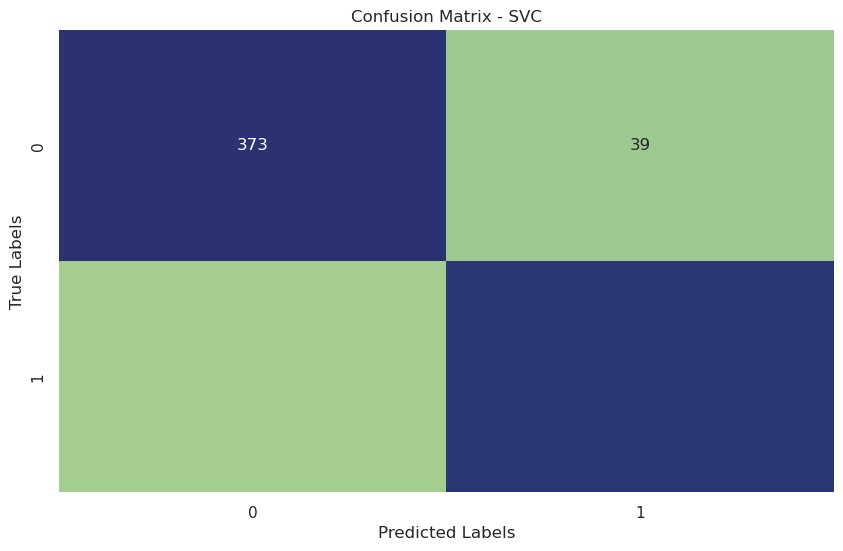


Accuracy of Support Vector Classifier: 91.52119700748129 



In [53]:
conf_matrix = confusion_matrix(y_test, svc_predicted)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='crest', cbar=False)
plt.title('Confusion Matrix - SVC')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("\nAccuracy of Support Vector Classifier:", svc_acc_score * 100, '\n')

Accuracy of Support Vector Classifier: 91.52119700748129

# 6.Receiver Operator Characteristic (ROC)

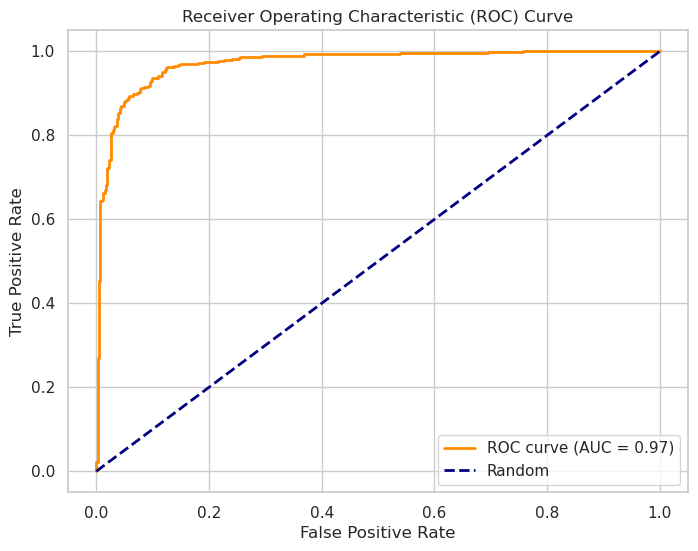

In [54]:
y_prob = best_svc_model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Another common metric is the Area Under the Curve, or AUC. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

0.90 - 1.00 = excellent
0.80 - 0.90 = good
0.70 - 0.80 = fair
0.60 - 0.70 = poor
0.50 - 0.60 = fail